# This notebook plots collocated MCS precipitation as a function of PWV from a single tracker

## The collocated MCS precipitation and PWV data is produced by:
- /src/calc_mcs_pcp_envs_pairs.py

In [1]:
import numpy as np
import xarray as xr
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

tracker = 'PyFLEXTRKR'

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        # 'm8': 'ICON',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'obsv7': 'OBSv7',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        # 'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm12': 'SCREAMv1',
    }

# Input files
indir = f'{rootdir}/{tracker}/'
infiles = {key:f'{indir}mcs_intqv_{PHASE}_{value}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/{tracker}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/PyFLEXTRKR/


## Check if input files exist

In [3]:
for key, value in infiles.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_intqv_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_intqv_Summer_OBSv7.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_intqv_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_intqv_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_intqv_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_intqv_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_intqv_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_intqv_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_intqv_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer//PyFLEXTRKR/mcs_intqv_Summer_SCREAMv1.nc: True


## Read data

In [4]:
# Read all files and combine them
ds = xr.open_mfdataset(list(infiles.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds['source'] = list(name_map.keys())
ds

<xarray.Dataset>
Dimensions:         (source: 10, bins: 44)
Coordinates:
  * bins            (bins) float64 6.0 8.0 10.0 12.0 ... 86.0 88.0 90.0 92.0
  * source          (source) <U5 'obs' 'obsv7' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables:
    total_land      (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_land        (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    total_ocean     (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_ocean       (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    total_land_ns   (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_land_ns     (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    total_ocean_ns  (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
    mcs_ocean_ns    (source, bins) float64 dask.array<chunksize=(1, 44), meta=np.ndarray>
Attributes:
    title:             Precipitation by environments
    lon_bounds:        [-180  180]
    lat_bounds:        [-15  30]
    landfrac_thresh:   0.9
    oceanfrac_thresh:  0.0
    contact:           Zhe Feng, zhe.feng@pnnl.gov
    created_on:        Tue Feb 27 19:15:36 2024

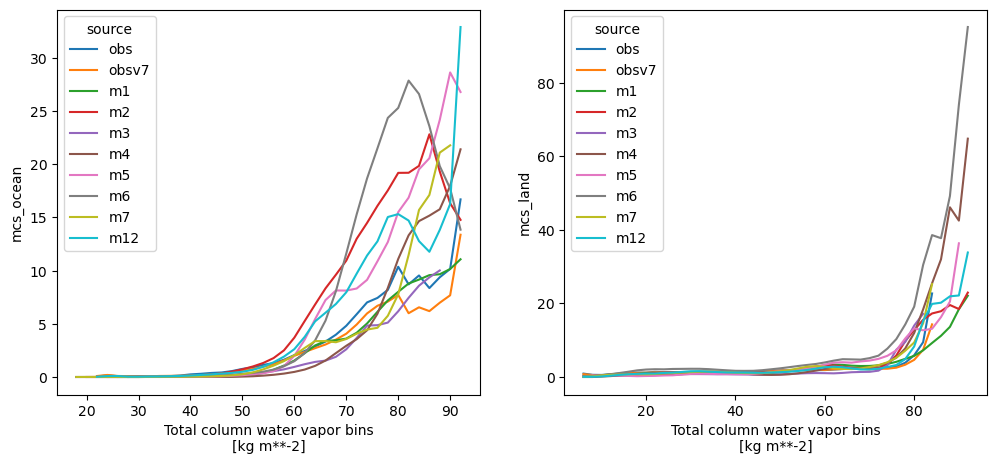

In [5]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
ds.mcs_ocean.plot.line(x='bins', ax=axes[0])
ds.mcs_land.plot.line(x='bins', ax=axes[1])

In [6]:
# Min pdf threshold
min_pdf_thresh = 1e-4
# min_pdf_thresh = 1e-6

In [7]:
# Normalize the number of samples in each bin by the total sample
mcs_ocean_ns = ds.mcs_ocean_ns
total_ocean_ns = ds.total_ocean_ns
mcs_ocean_pdf = mcs_ocean_ns / mcs_ocean_ns.sum(dim='bins')
total_ocean_pdf = total_ocean_ns / total_ocean_ns.sum(dim='bins')

# Filter bins with insufficient samples
mcs_ocean = ds.mcs_ocean.where(mcs_ocean_pdf > min_pdf_thresh)
total_ocean = ds.total_ocean.where(total_ocean_pdf > min_pdf_thresh)

# Normalize the number of samples in each bin by the total sample
mcs_land_ns = ds.mcs_land_ns
total_land_ns = ds.total_land_ns
mcs_land_pdf = mcs_land_ns / mcs_land_ns.sum(dim='bins')
total_land_pdf = total_land_ns / total_land_ns.sum(dim='bins')

# Filter bins with insufficient samples
mcs_land = ds.mcs_land.where(mcs_land_pdf > min_pdf_thresh)
total_land = ds.total_land.where(total_land_pdf > min_pdf_thresh)

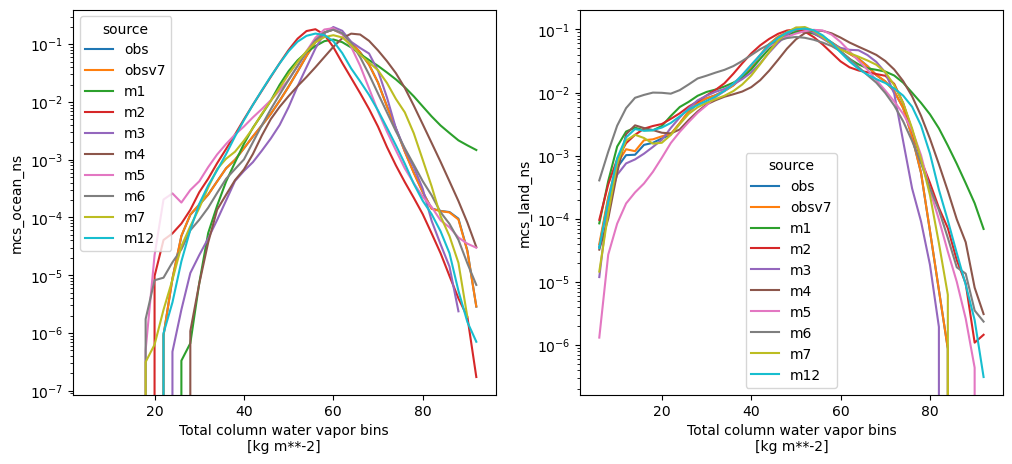

In [8]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean_pdf.plot.line(x='bins', ax=axes[0])
mcs_land_pdf.plot.line(x='bins', ax=axes[1])
axes[0].set_yscale('log')
axes[1].set_yscale('log')

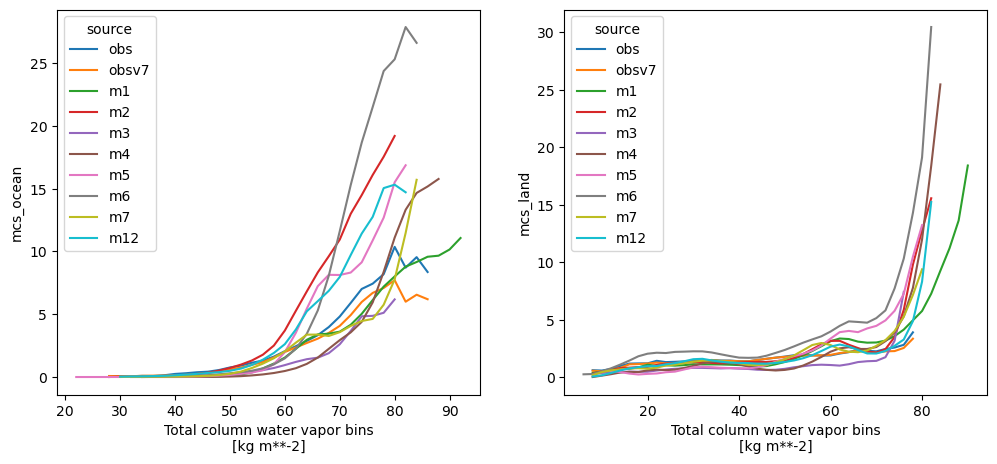

In [9]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
mcs_ocean.plot.line(x='bins', ax=axes[0])
mcs_land.plot.line(x='bins', ax=axes[1])

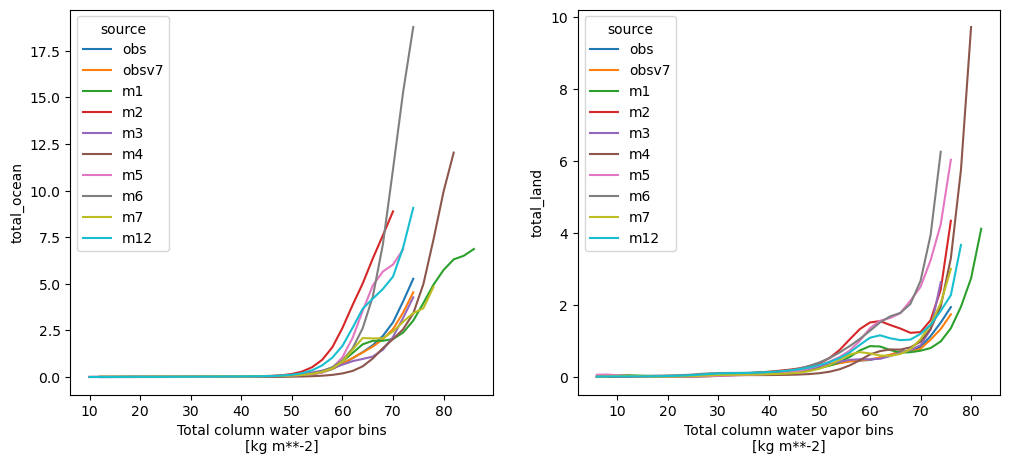

In [10]:
fig, axes = plt.subplots(1, 2, figsize=[12,5], dpi=100)
total_ocean.plot.line(x='bins', ax=axes[0])
total_land.plot.line(x='bins', ax=axes[1])

## Function to plot PWV vs. Precipitation for multiple trackers

In [11]:
def plot_lines_mxn(nrow, ncol, data_arr, xtime, 
                 titles=None, titles_loc=None, title_ha=None, xlabels=None, ylabels=None, xticks=None, legends=None, legend_loc=None, legend_ncol=None,
                 fontsize=None, legend_fontsize=None, legend_anchor=None, xlims=None, ylims=None, col_labels=None, wspace=None, hspace=None,
                 shade_dict=None, draw_arrow=False, text_dict=None, figname=None, figsize=None, inset_flag=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=wspace, hspace=hspace)
    
    lcolors = {
        'obs': 'k', 
        'obsv7': 'darkgray',
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    lw = 1.5
    lws = {
        'obs': lw*4, 
        'obsv7': lw*2,
        'm1': lw,
        'm2': lw, 
        'm3': lw,
        'm4': lw,
        'm5': lw,
        'm6': lw,
        'm7': lw,
        'm8': lw,
        'm9': lw,
        'm10': lw,
        'm11': lw,
        'm12': lw,
    }
    
    # Loop over column and row
    for col in range(0, ncol):
        for row in range(0, nrow):
            ax = plt.subplot(gs[row,col])
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            if row == 0:
                ax.text(xmid, 1.05, col_labels[col], fontsize=fontsize*1.5, ha='center', transform=ax.transAxes)

            # Share x-axis for all rows in each column
            if row < nrow - 1:
                # ax.get_xaxis().set_visible(False)
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(xlabels[col])
            
            # Plot data
            # for key, val in data_arr[row][col].items():
            for key in data_arr[row][col].source.data:
                idata = data_arr[row][col].sel(source=key)
                ax.plot(xtime, idata, lcolors[key], lw=lws[key], label=legends[key])
            ax.axvline(x=0, lw=1, ls='--', color='k')
            ax.grid(which='major', ls='--', lw=0.5)
            # ax.set_xlabel(xlabels[row][col])
            if ylabels is not None: ax.set_ylabel(ylabels[row][col])
            if xticks is not None: ax.set_xticks(xticks[col])
            if ylims is not None: ax.set_ylim(ylims[row][col][0], ylims[row][col][1])
            if xlims is not None: ax.set_xlim(xlims[col][0], xlims[col][1])
            # ax.set_title(titles[row][col], loc='left')
            # Make title within the axis
            flabel = ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
            flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
            if (row == 0) & (col == ncol-1):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc, ncol=legend_ncol, bbox_to_anchor=legend_anchor)
                # ax.legend(fontsize=legend_fontsize, loc=legend_loc[col], ncol=legend_ncol[col])
            # Fill background color
            if shade_dict:
                # xmin, xmax = ax.get_xlim()
                ax.axvspan(shade_dict['xmin'], shade_dict['xmax'], facecolor=shade_dict['color'], alpha=shade_dict['alpha'], transform=ax.get_xaxis_transform())
                # ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
                
            # Draw an arrow to show the direction of time increase
            if (draw_arrow) & (row == nrow-1):
                ax.annotate('', xy=(1, -0.3), xytext=(0, -0.3), xycoords='axes fraction',
                            arrowprops=dict(arrowstyle="->", facecolor='k', lw=3))
    # Add text to figure
    if text_dict is not None:
        fig.text(text_dict['x'], text_dict['y'], text_dict['text'], ha=text_dict['ha'], va=text_dict['va'], fontsize=text_dict['fontsize'])

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

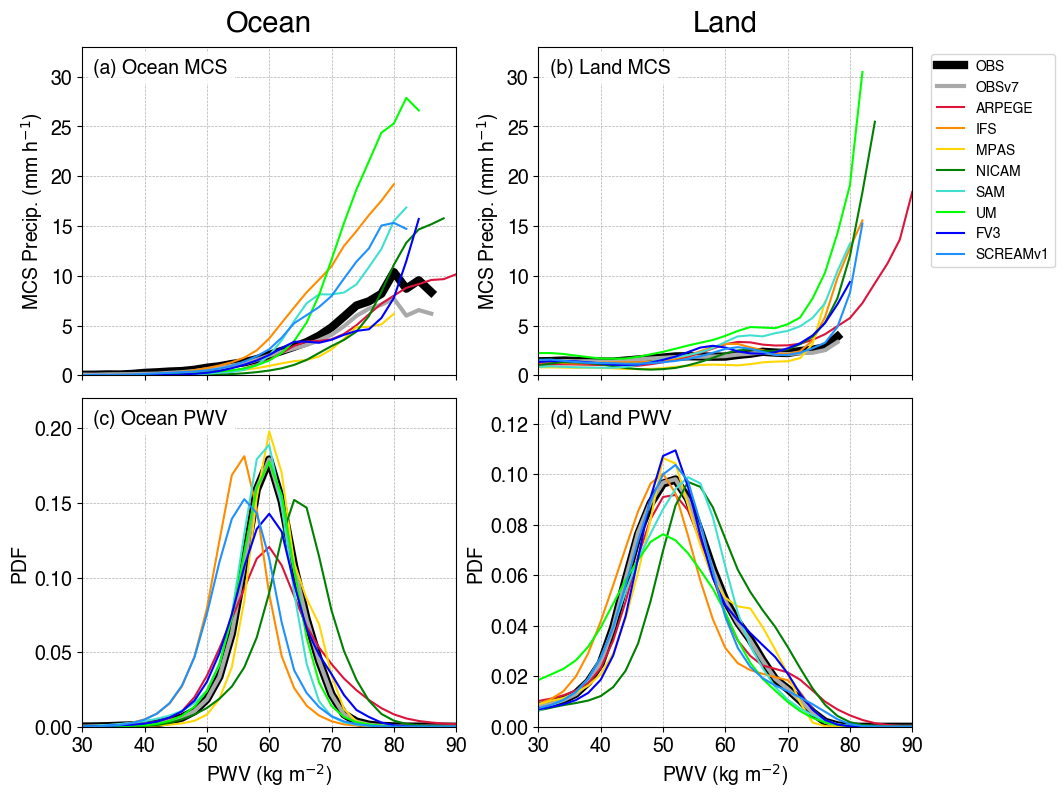

In [12]:
# Data array [row][col]
data_arr = [
    [mcs_ocean, mcs_land],
    [mcs_ocean_pdf, mcs_land_pdf],
]
xtime = mcs_ocean.bins
legends = name_map
nrow = len(data_arr)
ncol = 2
col_labels = ['Ocean', 'Land']
titles = [
    ['(a) Ocean MCS', '(b) Land MCS',],
    ['(c) Ocean PWV', '(d) Land PWV',],
]
titles_loc = [0.03, 0.92]
title_ha = 'left'
xlabels = ['PWV (kg m$^{-2}$)','PWV (kg m$^{-2}$)']
ylabels = [['MCS Precip. (mm h$^{-1}$)', 'MCS Precip. (mm h$^{-1}$)'],['PDF', 'PDF']]
xticks = None
xlims = [(30,90),(30,90)]
ylims = [[(0,33),(0,33)],[(0,0.22),(0,0.13)]]

legend_loc = 'upper right'
legend_ncol = 1
legend_anchor = (1.4, 1)
fontsize = 14
legend_fontsize = 10
figsize = [10,8]
wspace = 0.22
hspace = 0.07
# text_dict = {'text': f'{diameter_km:.0f}km', 'x': 1.0, 'y':0.96, 'ha':'right', 'va':'center', 'fontsize':fontsize*1.5}
text_dict = None
# shade_dict = {'xmin':60, 'xmax':70, 'color':'lightskyblue', 'alpha':0.2}
shade_dict = None
figname = f'{figdir}mcs_pwv_collocated_ocean_land_{tracker}.png'
figname
fig = plot_lines_mxn(nrow, ncol, data_arr, xtime, 
                   titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol,
                   fontsize=fontsize, legend_fontsize=legend_fontsize, legend_anchor=legend_anchor, xlims=xlims, ylims=ylims, col_labels=col_labels, wspace=wspace, hspace=hspace,
                   shade_dict=shade_dict, draw_arrow=False, text_dict=text_dict, figname=figname, figsize=figsize)

In [13]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/PyFLEXTRKR/mcs_pwv_collocated_ocean_land_PyFLEXTRKR.png'